In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import (
    Params, T, get_T1_and_T2, R0, plot_total, DATE_FORMAT, total_to_csv, save_to_json, save_bundle,
    makedir_if_not_there
)

from const import STATE, COLORS, NUM_STATES,  STATES


In [3]:
p0_time = pkl.load(open('output/p0_time.pkl', 'rb'))
lockdown_time = T('23/01/2020')
days_before_ld  = (lockdown_time -  p0_time).days
params_before = pkl.load(
    open('output/params_before_lockdown.pkl', 'rb')
)

params_after = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

bed_info = pkl.load(open('data/bed_info.pkl', 'rb'))


In [4]:
total_days = 720
def one_run(infection_factor, days_before_lift):
    alpha_list = [
        (0, params_before.alpha),
        (days_before_ld, params_after.alpha),
        (days_before_lift, infection_factor * params_after.alpha)
    ]
    beta_list = [
        (0, params_before.beta),
        (days_before_ld, params_after.beta),
        (days_before_lift, infection_factor * params_after.beta)
    ]

    p = Params(
        alpha=alpha_list,
        beta=beta_list,
        stages=[days_before_ld, days_before_lift],
        initial_num_E=1,
        initial_num_I=0,
        initial_num_M=0,
        mu_ei=params_after.mu_ei,
        mu_mo=params_after.mu_mo,
        k_days=params_after.k_days,
        x0_pt=params_after.x0_pt,          
    )

    total, delta, increase, trans, stats = do_simulation(total_days, bed_info, p, p0_time=p0_time)
    bundle = [total, delta, increase, trans]
    return infection_factor, days_before_lift, bundle, stats

In [5]:
infection_factors = [1.05, 1.1, 1.15, 1.2, 1.25]
days_list = np.arange(150, 361, step=30)
rows = Parallel(n_jobs=-1)(
    delayed(one_run)(infection_factor, days)
    for days in days_list
    for infection_factor in infection_factors
)

In [6]:
'{:.2f}'.format(1.10), '{:.2f}'.format(1.15)

('1.10', '1.15')

infection_factor= 1.05
days = 150
[2.729578619522789, 1.9758925384405943, 1.9608182026395164]


/home/cloud-user/code/covid-19/helpers.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['index'] = df.index
/home/cloud-user/code/covid-19/helpers.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['value'] = subdf[state].copy()
/home/cloud-user/code/covid-19/helpers.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
infection_factor= 1.1
days = 150
[2.729578619522789, 1.9758925384405943, 1.996725245494924]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
infection_factor= 1.15
days = 150
[2.729578619522789, 1.9758925384405943, 2.0321088086941064]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
infection_factor= 1.2
days = 150
[2.729578619522789, 1.9758925384405943, 2.0901898530703353]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
infection_factor= 1.25
days = 150
[2.729578619522789, 1.9758925384405943, 2.602081682669456]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
infection_factor= 1.05
days = 180
[2.729578619522789, 1.973939472631143, 1.961027621945343]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
infection_factor= 1.1
days = 180
[2.729578619522789, 1.973939472631143, 1.9968673605259155]
['29/11/19' '21/04/20' '12/09/20' '0

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


infection_factor= 1.1
days = 270
[2.729578619522789, 1.9729079908078173, 2.002109908419638]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
infection_factor= 1.15
days = 270
[2.729578619522789, 1.9729079908078173, 2.036184560673752]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
infection_factor= 1.2
days = 270
[2.729578619522789, 1.9729079908078173, 2.066087996166387]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
infection_factor= 1.25
days = 270
[2.729578619522789, 1.9729079908078173, 2.4447240696352726]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
infection_factor= 1.05
days = 300
[2.729578619522789, 1.972880281115533, 1.9682477556211355]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
infection_factor= 1.1
days = 300
[2.729578619522789, 1.972880281115533, 2.0034569654227945]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
infection_factor= 1.15
days = 300
[2

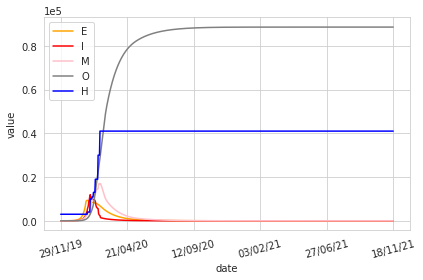

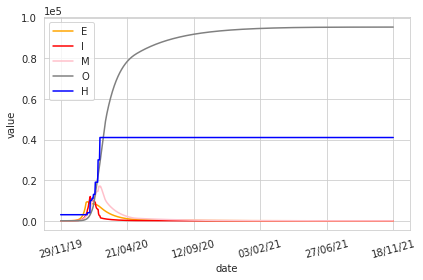

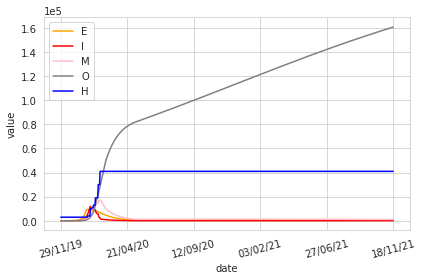

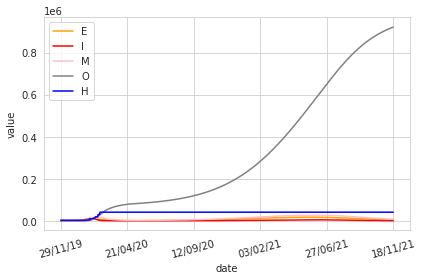

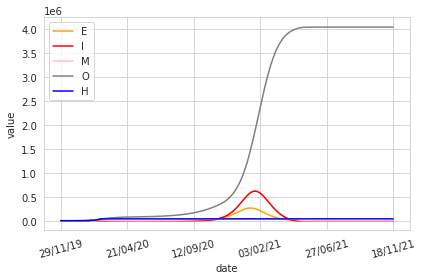

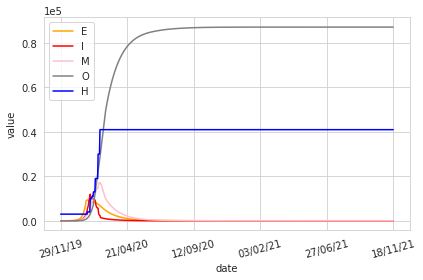

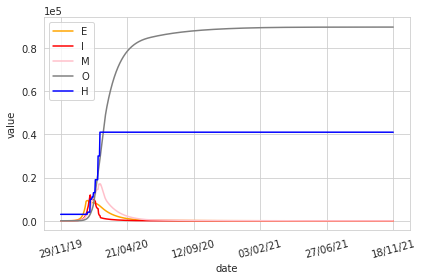

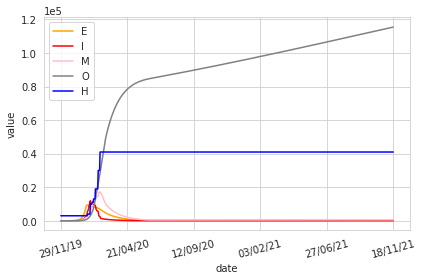

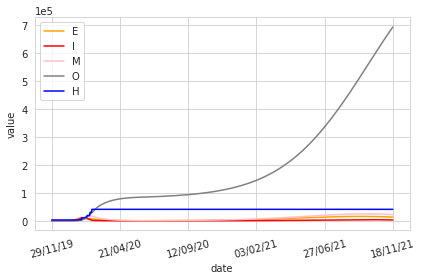

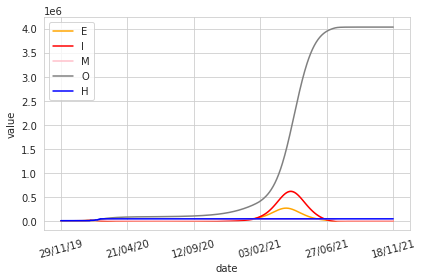

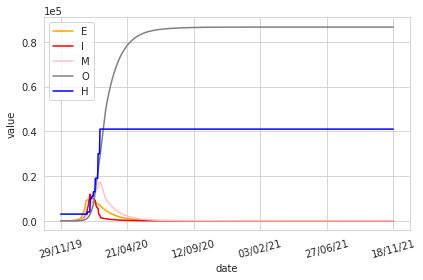

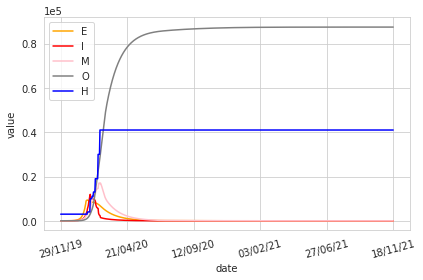

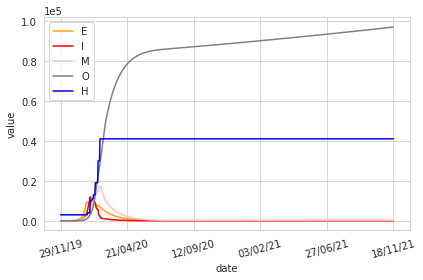

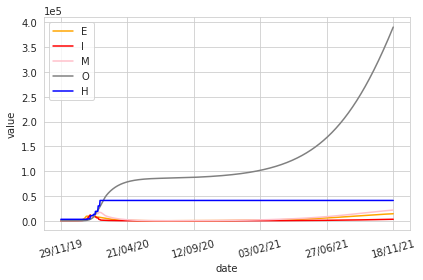

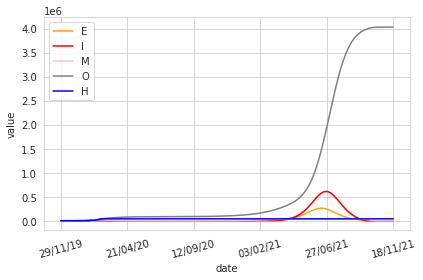

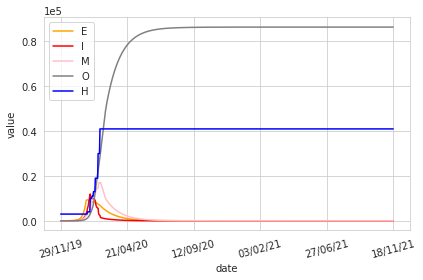

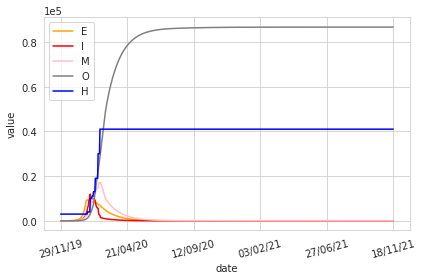

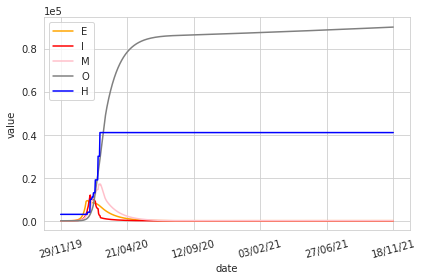

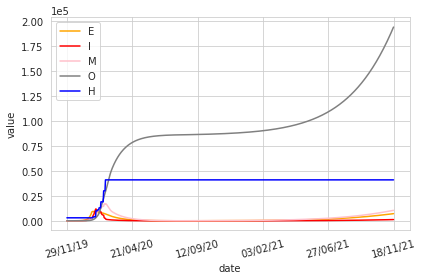

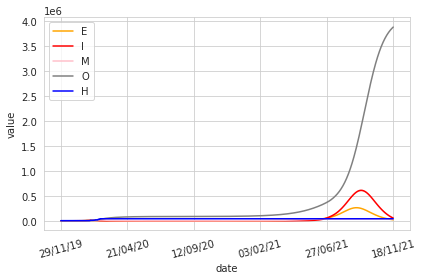

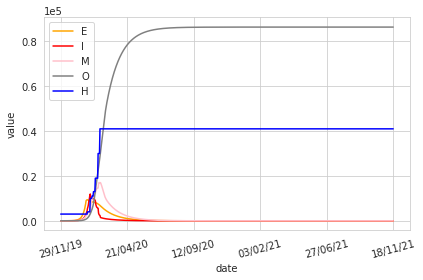

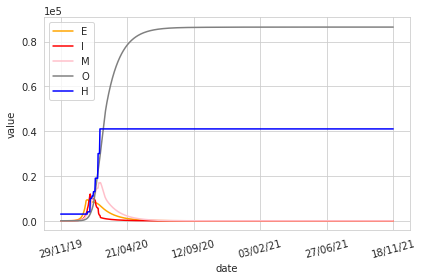

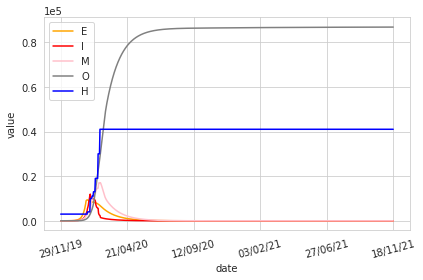

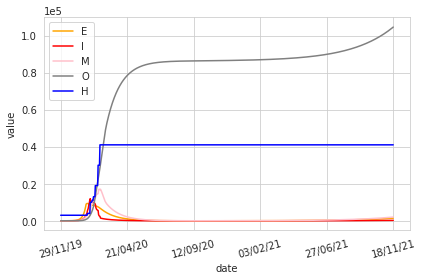

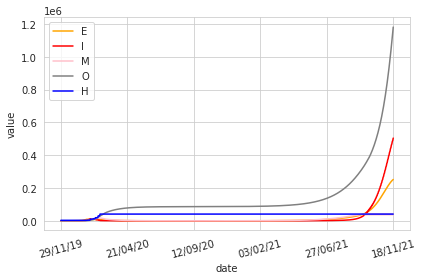

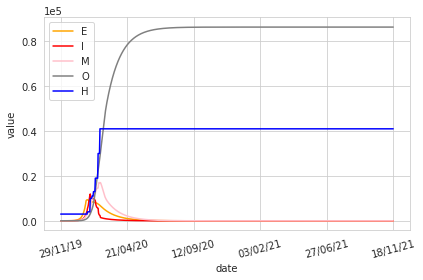

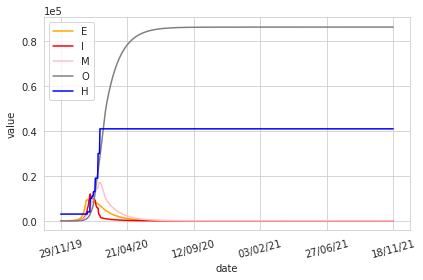

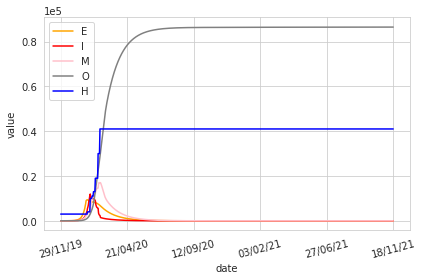

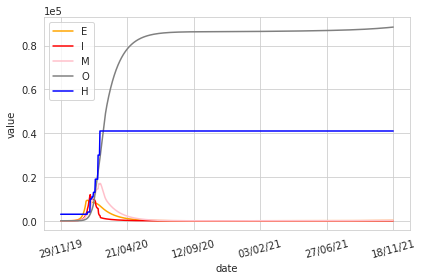

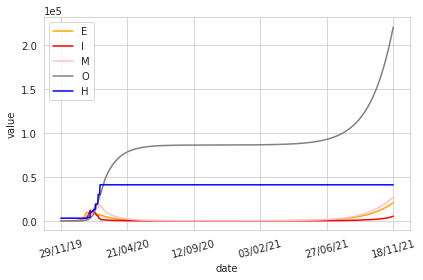

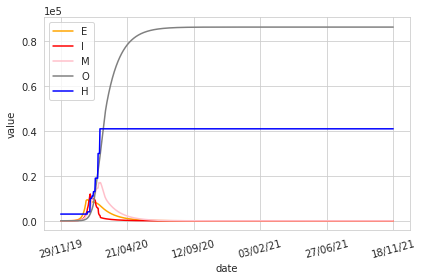

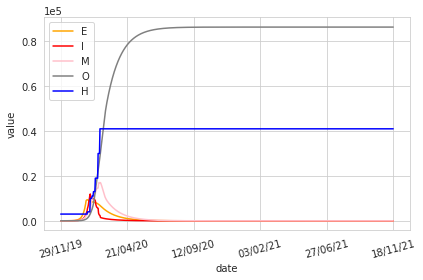

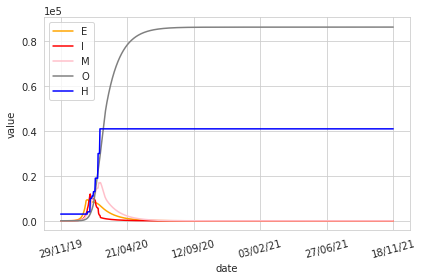

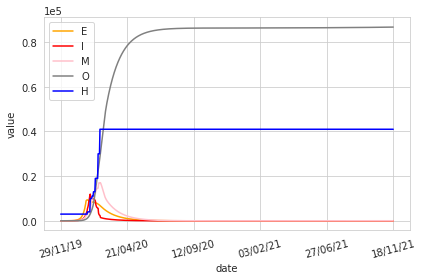

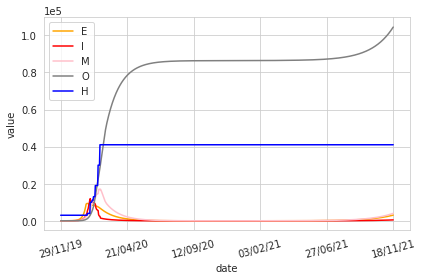

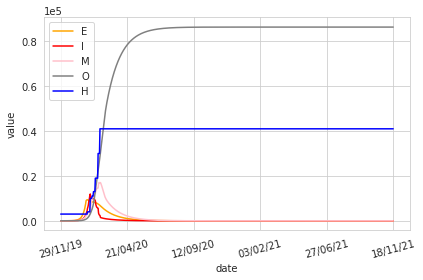

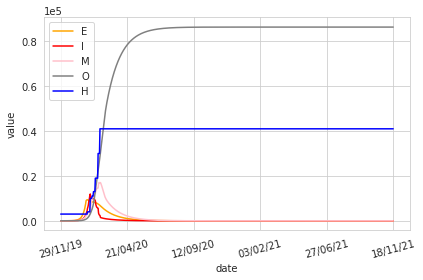

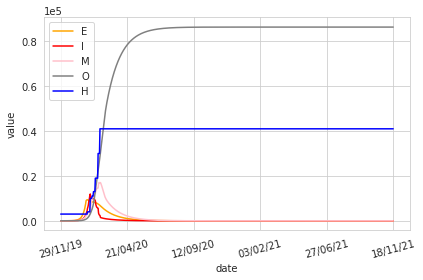

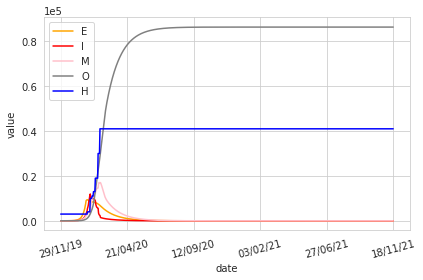

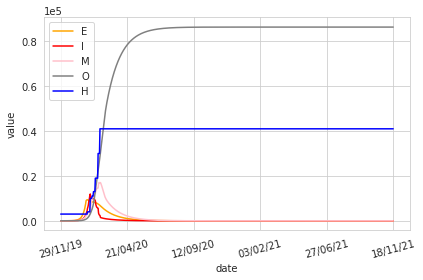

In [7]:
r0_rows = []
for infection_factor, days, bundle, stats in rows:    
    print('infection_factor=', infection_factor)
    print('days =', days)
    r0_row = [t[-1] for t in stats['R0_by_stage'].values()]
    print(r0_row)
    r0_rows.append([days] + r0_row)
    fig, ax = plot_total(bundle[0], p0_time,  total_days)
    
    infection_factor_str = '{:.2f}'.format(infection_factor)
    makedir_if_not_there(f'figs/lift-lockdown/{infection_factor_str}/')
    fig.savefig(f'figs/lift-lockdown/{infection_factor_str}/{days}.pdf')
    
    save_bundle(
        bundle, p0_time, total_days,
        f'output/tbl/lift-lockdown/{infection_factor_str}/{days}/'
    )
    save_to_json(stats, f'output/tbl/lift-lockdown/{infection_factor_str}/{days}/stats.txt')

In [8]:
df = pd.DataFrame(r0_rows, columns=['factor', 'before-ld', 'after-ld', 'after-ld-lift'])
df.to_csv('output/tbl/lift-lockdown/r0.csv', index=None)
df

,factor,before-ld,after-ld,after-ld-lift
0,150,2.729579,1.975893,1.960818
1,150,2.729579,1.975893,1.996725
2,150,2.729579,1.975893,2.032109
3,150,2.729579,1.975893,2.090190
4,150,2.729579,1.975893,2.602082
5,180,2.729579,1.973939,1.961028
6,180,2.729579,1.973939,1.996867
7,180,2.729579,1.973939,2.031447
8,180,2.729579,1.973939,2.084867
9,180,2.729579,1.973939,2.600757
